###  Data Entries: 
0 Bound, 1 Date + Time, 2 Seq No, 3 Lane, 4 Speed, 5 Class, 6 No of Axle, [ Axle Weight, Axle Spacing]

---
### <span style="color:red"> Methods and Procedures </span>


#### Data Cleaning
- Sort the data based on Date > Bound > lane   DONE
- obtain the gap distance    DONE

#### Fitting and Regression
- Find the daily average vehicle flow  DONE
- Find the Variation in Traffic flow across different times of the day DONE
- Find the variation in LDV:HDV ratio across different times of the day  GAVE UP
- Find the variation in (Traffic Volume in hour)/(Traffic Volume in day) across different times of the day [Reference](https://medium.com/hal24k-techblog/a-guide-to-generating-probability-distributions-with-neural-networks-ffc4efacd6a4) 
- Find the PDF of the vehicle weight of LDV  DONE 
- Find the PDF of the vehicle weight of HDV  DONE
- Find the Relation between parameters with the below methods  

#### Monte Carlo Simluation
- Set up an environment for simulation. Refer to your IR. 
- Run for 2400 years (USE SEED to make sure the value is same every time) -> maybe do it a few times and take the average?
- Obtain max load effect. -> Transition to SAP2000
- Then maybe measure the load effect with varying parameters to plot a 3d surface. (but what parameters should I vary with?)

---

### Relationship between each entries: 
 - Time of the day -> Proportion of Vehicle Class
   - Vehicle Class -> Vehicle Speed ? Need to see if there is a relationship or not. 
      - Vehicle Class + Vehicle Speed -> Gap Distance  
        //
   - Vehicle Class -> Axle Number 
      - Axle number -> Total Weight & Axle Weight

Multiple Lasso/Ridge Regression or polynomial regression would be used to draw the relationships of the above figures. 

### Assumptions and Relationships: 
- the Traffic composition relates to the time of the day
- Gap distance between vehicles is determined by the vehicle speed and the vehicle class ie. weight

In [210]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [211]:
all_data= pd.read_excel('output.xlsx')
# usecols='A:I'

In [212]:
len(all_data.index)

87502

#### Calculates the Gap distance

In [213]:
# all_data.loc[:,'Seq No':'Class'].head()
all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])
all_data['Date'] = pd.to_datetime(all_data['Date + Time']).dt.date
all_data['Date'].unique()

all_data = all_data.sort_values(['Date','Bound', 'Lane','Seq No'])

all_data['Same Bound'] = all_data['Bound'] == all_data['Bound'].shift(1)
all_data['Same Lane'] = all_data['Lane'] == all_data['Lane'].shift(1)    
# if all_data.loc['Bound'].eq(all_data.loc['Bound'].shift(1)) and all_data.loc['Lane'].eq(all_data.loc['Lane'].shift(1)):
#     all_data['Gap Distance'] = all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])
# else:
#     all_data['Gap Distance'] = pd.NA

filter1 = all_data['Same Bound'] == True
filter2 = all_data['Same Lane'] == True
not_filter1 = all_data['Same Bound'] == False
not_filter2 = all_data['Same Lane'] == False

change = all_data['Date + Time'].diff().dt.seconds
# all_data['Speed'] * (all_data['Date + Time'].shift(1) - all_data['Date + Time'])

all_data.loc[filter1 & filter2, 'Gap Distance'] = change
all_data.loc[not_filter1, 'Gap Distance'] = pd.NA
all_data.loc[not_filter2, 'Gap Distance'] = pd.NA


# all_data = all_data.fillna(all_data['Gap Distance'].mean())

cols = ['Gap Distance']
all_data.loc[:,cols] = all_data.loc[:,cols].bfill()


/var/folders/py/yncddnwd6kn7d9dzfmz1kcbm0000gn/T/ipykernel_6194/3875649319.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data['Date + Time'] = pd.to_datetime(all_data['Date + Time'])


In [214]:
subset = all_data.drop(columns=['Date + Time','Date']).loc[:,:'No of Axle']
Weight_Gap_Corr = subset.corr()
print(Weight_Gap_Corr)

              Gap Distance  Total Weight     Bound    Seq No      Lane   
Gap Distance      1.000000      0.046639 -0.112323  0.092324  0.043471  \
Total Weight      0.046639      1.000000 -0.031601  0.034114 -0.388749   
Bound            -0.112323     -0.031601  1.000000  0.038872  0.086363   
Seq No            0.092324      0.034114  0.038872  1.000000  0.042279   
Lane              0.043471     -0.388749  0.086363  0.042279  1.000000   
Speed             0.033896     -0.216113 -0.021953 -0.036410  0.401576   
Class             0.041409      0.764752 -0.022125  0.035003 -0.390537   
No of Axle        0.039531      0.827129 -0.024496  0.032235 -0.342704   

                 Speed     Class  No of Axle  
Gap Distance  0.033896  0.041409    0.039531  
Total Weight -0.216113  0.764752    0.827129  
Bound        -0.021953 -0.022125   -0.024496  
Seq No       -0.036410  0.035003    0.032235  
Lane          0.401576 -0.390537   -0.342704  
Speed         1.000000 -0.170976   -0.196007  
Clas

-------

It can be seen that there is not much relationship between Gap distace and Total Weight

There is relationship between speed and lane number, but should not affect the calculation of load effect. 


Class 1 - Motor cycles

Class 2 - Private cars


Class 3 - Light buses

Class 4 - Light Goods Vehicles

Class 5 - Medium Goods Vehicles

Class 6 - Rigid Heavy Goods Vehicles

Class 7 - Articulated Heavy Goods Vehicles

Class 8 - Buses and Coaches

Class 9 - Unclassified

## Average Vehicular Flow

In [215]:
date_list = all_data['Date'].unique()
avf_list = []
for date in date_list: 
    avf_list.append(round(len(all_data[all_data['Date']==date].index),2))
dict = {'Date': date_list, "Daily Vehicular Flow": avf_list}
AVFdf = pd.DataFrame(dict)
print(AVFdf)
mean_vf = AVFdf["Daily Vehicular Flow"].mean()
sd_vf = AVFdf["Daily Vehicular Flow"].std()
print(mean_vf, sd_vf)


         Date  Daily Vehicular Flow
0  2000-01-01                 21219
1  2000-08-23                  8882
2  2000-11-21                  6398
3  2000-11-22                  4771
4  2004-12-30                 46232
17500.4 17312.643885322657


[array([82, 76, 76, ..., 99, 84, 91]), array([63, 72, 72, ..., 88, 94, 86]), array([74, 74, 78, ..., 88, 88, 88]), array([72, 69, 69, ..., 91, 78, 79]), array([86, 74, 63, ..., 82, 79, 82])]


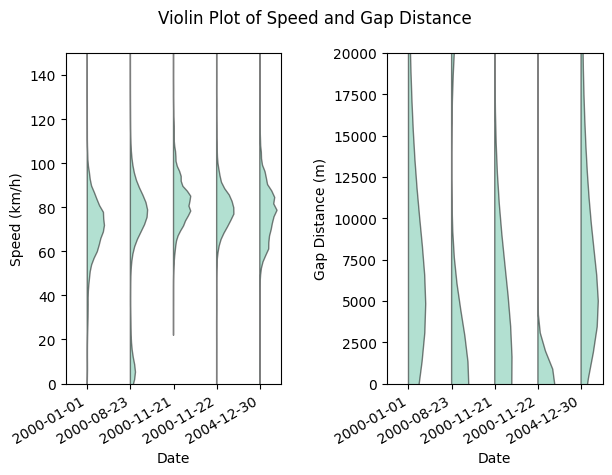

In [216]:
from statsmodels.graphics.boxplots import violinplot

# df = pd.DataFrame(np.random.rand(7, 100), columns=['y']*100)
# df.index = pd.date_range(datetime.today(), periods=7).tolist()
# df
speed_list = []
gap_list = []
for date in date_list:
    speed_list.append(np.array(all_data[all_data['Date']==date]['Speed']))
    gap_list.append(np.array(all_data[all_data['Date']==date]['Gap Distance']))
print(speed_list)
fig, (ax1, ax2) = plt.subplots(1,2)
violinplot(data=speed_list, ax=ax1, labels=date_list, side='right', show_boxplot=False)
violinplot(data=gap_list, ax=ax2, labels=date_list, side='right', show_boxplot=False)
# plt.xlabel('Date')
# plt.ylabel('Speed (km/h)')
plt.setp(ax1, ylim=[0,150], xlabel = 'Date', ylabel = 'Speed (km/h)')
plt.setp(ax2, ylim=[0,20000], xlabel = 'Date', ylabel = 'Gap Distance (m)')
plt.suptitle('Violin Plot of Speed and Gap Distance')
fig.tight_layout()
fig.autofmt_xdate()

## Hourly Vehicular Flow

#### This assumes that all data are measured from the same bridge. Since for different bridges, the number of lanes would affect the expected vehicular flow.

### in Unit of Minutes

In [217]:
from datetime import time as t
def generate_time(time_list):
    for h in range(24):
        for m in range(60):
            time_list.append(t(h,m).strftime("%H:%M"))
    return

# Create the Time column, where it is in the string format of hour:minute in 1 minute increments
all_data['Time'] = all_data['Date + Time'].dt.round('1min')
all_data['Time'] = all_data['Time'].dt.strftime("%H:%M")

# Make a time list to store all the x data from 00:00 to 23:59
time_list = []
generate_time(time_list)
dict = {"Time": time_list}

# Loops over the number of recorded dates
total_entries = 0
for date in date_list:
    vehicle_flow = []
    # Loops over each minute
    for time in time_list:
        # Tallies the number of vehicle that is recorded in that minute. -> convert the unit from veh/min to veh/hr
        # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
        vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Time']==time)].index) * 60)

    dict[date] = vehicle_flow
    for item in vehicle_flow:
        total_entries += item / 60

print(total_entries)
VF_testing = pd.DataFrame(dict)

87502.0


In [218]:
pd.set_option('display.max_rows', 500)
print(VF_testing)

       Time  2000-01-01  2000-08-23  2000-11-21  2000-11-22  2004-12-30
0     00:00           0           0           0           0        1440
1     00:01           0           0           0           0        1860
2     00:02           0           0           0           0        2100
3     00:03           0           0           0           0        1980
4     00:04           0           0           0           0        2460
...     ...         ...         ...         ...         ...         ...
1435  23:55           0           0           0           0         660
1436  23:56           0           0           0           0         840
1437  23:57           0           0           0           0         900
1438  23:58           0           0           0           0         480
1439  23:59           0           0           0           0        1140

[1440 rows x 6 columns]


1440


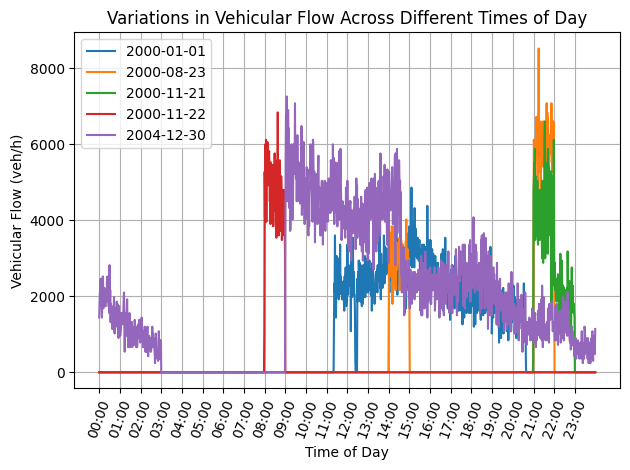

In [219]:
# import numpy as np
# for date in date_list:
#     print(VF_testing[date])
#     VF_testing[VF_testing[date] == 0] = np.nan

# print(hourly_vehicle_flow)
print(len(time_list))
for date in date_list:
    # removes the time data for when there is no vehicle recorded
    # tmp = np.array(VF_testing[date].astype(float))
    # tmp[tmp==0] = np.nan
    
    plt.plot(VF_testing['Time'], VF_testing[date], label=date)
    # plt.plot(VF_testing['Time'], VF_testing[date], label=date)
plt.xticks(time_list[::60], rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

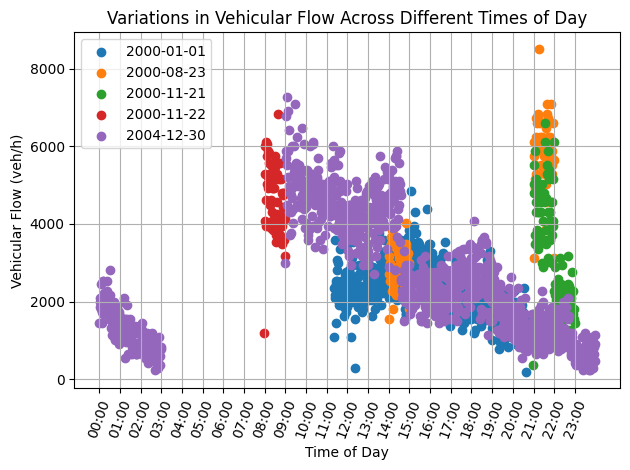

In [220]:
for date in date_list:
    tmp = np.array(VF_testing[date].astype(float))
    tmp[tmp==0] = np.nan
    plt.scatter(VF_testing['Time'], tmp, label=date)
    # plt.plot(VF_testing['Time'], VF_testing[date], label=date)
plt.xticks(time_list[::60], rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

### In Unit of Hours

In [221]:
from datetime import time as t
def generate_time(time_list):
    for h in range(24):
        time_list.append(t(h).strftime("%H"))
    return

# Create the Time column, where it is in the string format of hour:minute in 1 minute increments
all_data['Time'] = all_data['Date + Time'].dt.floor('h')
all_data['Time'] = all_data['Time'].dt.strftime("%H")

# Make a time list to store all the x data from 00:00 to 23:59
time_list = []
generate_time(time_list)
dict = {"Time": time_list}

# Loops over the number of recorded dates
for date in date_list:
    vehicle_flow = []
    # Loops over each minute
    for time in time_list:
        # Tallies the number of vehicle that is recorded in that minute. -> convert the unit from veh/min to veh/hr
        # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
        tmp = all_data[(all_data['Date']==date) & (all_data['Time']==time)]
        hourly_flow = len(tmp.index)
        if hourly_flow < 100: 
            hourly_flow = 0
        vehicle_flow.append(hourly_flow)
    dict[date] = vehicle_flow
# print()
VF_testing = pd.DataFrame(dict)
VF_testing

,Time,2000-01-01,2000-08-23,2000-11-21,2000-11-22,2004-12-30
0,00,0,0,0,0,1746
1,01,0,0,0,0,1155
2,02,0,0,0,0,760
3,03,0,0,0,0,0
4,04,0,0,0,0,0
5,05,0,0,0,0,0
6,06,0,0,0,0,0
7,07,0,0,0,0,0
8,08,0,0,0,4709,0
9,09,0,0,0,0,5161


24


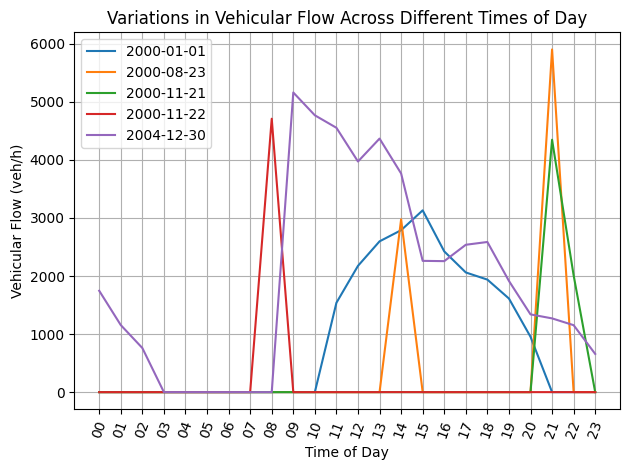

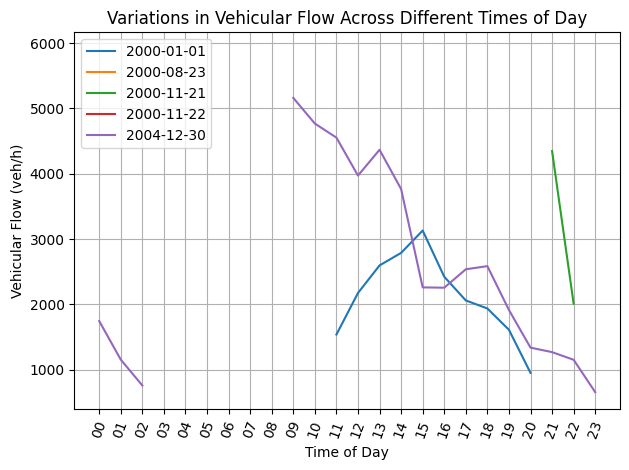

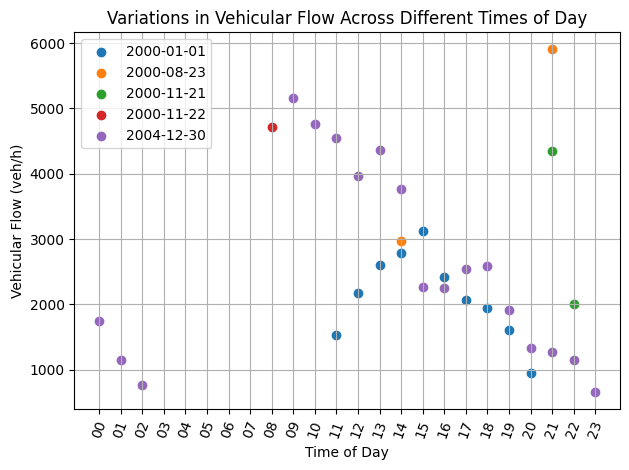

In [222]:

print(len(time_list))
# Print one with the 0 value
for date in date_list:
    # removes the time data for when there is no vehicle recorded
    tmp = np.array(VF_testing[date].astype(float))
    tmp[tmp==0] = np.nan
    
    plt.plot(VF_testing['Time'], VF_testing[date], label=date)
    # plt.plot(VF_testing['Time'], VF_testing[date], label=date)

plt.xticks(time_list, rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

# Print oen without 0 values
for date in date_list:
    # removes the time data for when there is no vehicle recorded
    tmp = np.array(VF_testing[date].astype(float))
    tmp[tmp==0] = np.nan
    
    plt.plot(VF_testing['Time'], tmp, label=date)
    # plt.plot(VF_testing['Time'], VF_testing[date], label=date)

plt.xticks(time_list, rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

# Scatter Plot
for date in date_list:
    # removes the time data for when there is no vehicle recorded
    tmp = np.array(VF_testing[date].astype(float))
    tmp[tmp==0] = np.nan
    
    plt.scatter(VF_testing['Time'], tmp, label=date)
    # plt.plot(VF_testing['Time'], VF_testing[date], label=date)

plt.xticks(time_list, rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

#### Now Taking the Average Value across each day

In [223]:
# def generate_time(time_list):
#     for h in range(24):
#         time_list.append(t(h).strftime("%H"))
#     return

# # Create the Time column, where it is in the string format of hour:minute in 1 minute increments
# all_data['Time'] = all_data['Date + Time'].dt.floor('h')
# all_data['Time'] = all_data['Time'].dt.strftime("%H")

# # Make a time list to store all the x data from 00:00 to 23:59
# time_list = []
# generate_time(time_list)
# dict = {"Time": time_list}

# vehicle_flow = []
# # Loops over each minute
# for time in time_list:
#     # Tallies the number of vehicle that is recorded in that minute. -> convert the unit from veh/min to veh/hr
#     # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
#     tmp = all_data[all_data['Time']==time]
#     no_of_dates_involved = len(tmp['Date'].unique())
#     if no_of_dates_involved != 0:
#         hourly_flow_value = len(tmp.index) / no_of_dates_involved
#     vehicle_flow.append(hourly_flow_value)
#     dict['Vehicle Flow'] = vehicle_flow

# VF_testing = pd.DataFrame(dict)

0     1746.000000
1     1155.000000
2      760.000000
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8     4709.000000
9     5161.000000
10    4768.000000
11    3046.000000
12    3073.500000
13    3482.000000
14    3177.000000
15    2696.000000
16    2340.000000
17    2299.500000
18    2262.000000
19    1763.500000
20    1146.000000
21    3839.666667
22    1582.000000
23     658.000000
Name: Average, dtype: float64


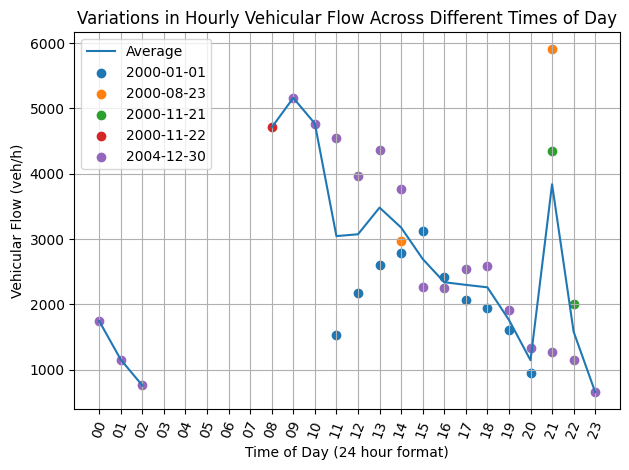

In [224]:

VF_testing['Total'] = VF_testing.iloc[:,1:6].sum(axis=1)
VF_testing['Unique Dates'] = VF_testing.iloc[:,1:6].astype(bool).sum(axis=1)

VF_testing['Average'] = VF_testing['Total'] / VF_testing['Unique Dates'] 
print(VF_testing['Average'])

# graph plot the average value
plt.plot(time_list, VF_testing['Average'], label='Average')


# Scatter Plot
for date in date_list:
    # removes the time data for when there is no vehicle recorded
    tmp = np.array(VF_testing[date].astype(float))
    tmp[tmp==0] = np.nan
    
    plt.scatter(VF_testing['Time'], tmp, label=date)

plt.xticks(time_list, rotation=70)
plt.legend(loc=0)
plt.grid()
plt.xlabel('Time of Day (24 hour format)')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Hourly Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()


In [276]:
# Defining Data
tmp = VF_testing.dropna(subset=["Average"])

# Building NN 
from keras.models import Sequential
from keras.layers import Dense

X_train       = tmp['Time'].astype(float)
y_train       = tmp['Average'].astype(float)

# essential preprocessing: imputation; substitute any 'NaN' with mean value 
X_train      = X_train.fillna(X_train.mean())


# parameters for keras
input_dim        =  1 # number of neurons in the input layer
n_neurons        = 100       # number of neurons in the first hidden layer
epochs           = 3000      # number of training cycles

# keras model
model = Sequential()        # a model consisting of successive layers
# input layer
model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))
# output layer, with one neuron
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal'))
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
history = model.fit(X_train,y_train, epochs=epochs, verbose=0, validation_split=0.2)

# use the model to predict the prices for the test data
y_predicted = model.predict(X_train)


1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 13ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


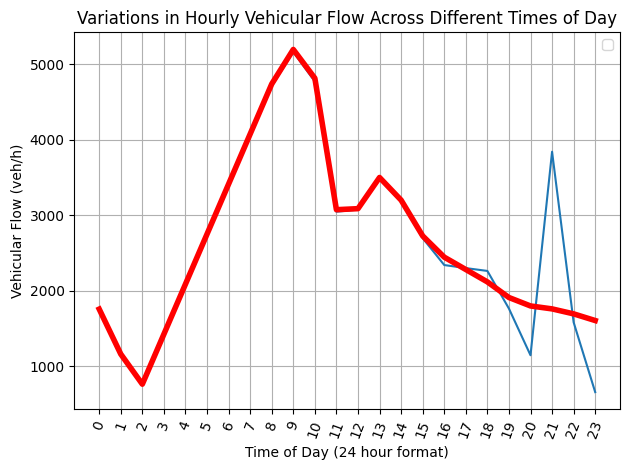

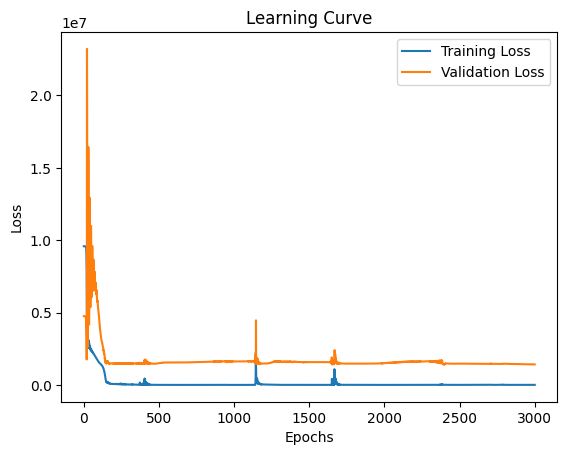

In [277]:
# Compute the output 
y_predicted = model.predict(X_train)

# X_train = sc.inverse_transform(X_train)

# Display the result
plt.plot(X_train, y_train)
plt.plot(X_train, y_predicted, 'r', linewidth=4)
plt.xticks(VF_testing['Time'].astype(int), rotation=70)
plt.legend(loc=0)
plt.grid()
plt.xlabel('Time of Day (24 hour format)')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Hourly Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

# Extract the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## ABANDONED (LDV : HDV at Varying Times of the Day)

In [227]:
# # print(time_list[::60])
# dict = {"Time": time_list}

# all_data['Hour'] = all_data['Date + Time'].dt.round('1h')
# all_data['Hour'] = all_data['Hour'].dt.strftime("%H:%M")


# for date in date_list:
#     LDV_vehicle_flow = []
#     HDV_vehicle_flow = []
#     for time in time_list:
#         # ? Times 60 for the total numebr of cars to convert: cars per min to cars per hour
#         LDV_vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Hour']==time) & (all_data['Class'].astype(int)<=2)].index) * 60)
#         HDV_vehicle_flow.append(len(all_data[(all_data['Date']==date) & (all_data['Hour']==time) & (all_data['Class'].astype(int)>2)].index) * 60)

#     dict[date.strftime("%Y%M%D") + 'LDV'] = LDV_vehicle_flow
#     dict[date.strftime("%Y%M%D") + 'HDV'] = HDV_vehicle_flow

#     print(len(vehicle_flow))

#     LDV_HDV_testing = pd.DataFrame(dict)

import numpy as np
import matplotlib.pyplot as plt
from datetime import time as t

def generate_time(time_list):
    for h in range(24):
        for m in range(60):
            time_list.append(t(h,m))
    return

total_list = []
time_list = []
generate_time(time_list)

for date in date_list:
    # print(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV'])
    # print(np.array(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV']))
    total_list = np.concatenate((total_list, (np.array(LDV_HDV_testing[date.strftime("%Y%M%D") + 'LDV']))))
time_list = time_list * len(date_list)

print(len(total_list))
print(len(time_list))

plt.scatter(total_list, time_list, label=date)
plt.xticks(time_list[::60], rotation=70)
plt.legend()
plt.grid()
plt.xlabel('Time of Day')
plt.ylabel('Vehicular Flow (veh/h)')
plt.title('Variations in Vehicular Flow Across Different Times of Day')
plt.tight_layout()
plt.show()

## LDV to HDV Ratio

In [228]:

# HDV
HDV = all_data.loc[(all_data['Class'].astype(int) > 2)| ((all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) > 6000))]
total_trucks = HDV[HDV.columns[0]].count()
# LDV - Private Vehicle and Motorbikes
PV = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) >= 1500) & (all_data['Total Weight'].astype(int) <= 6000) ]
# PV['Total Weight'].mode
total_cars = PV[PV.columns[0]].count()

# LDV - Motorbike
MB = all_data.loc[(all_data['Class'].astype(int) <= 2) & (all_data['Total Weight'].astype(int) < 1500) ]
total_motorbikes = MB[MB.columns[0]].count()

print([total_trucks,total_cars,total_motorbikes])
print(sum([total_trucks,total_cars,total_motorbikes]))

[32483, 29276, 25743]
87502


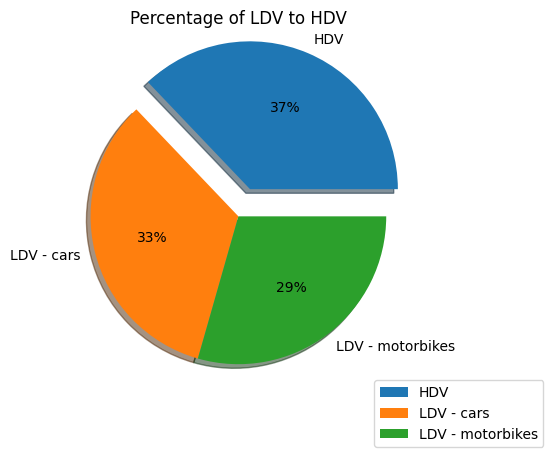

In [229]:
import numpy as np
import matplotlib.pyplot as plt

pie_chart_labels = ['HDV','LDV - cars','LDV - motorbikes']
myexplode = [0.2,0,0]

plt.pie(np.array([total_trucks,total_cars,total_motorbikes]),labels = pie_chart_labels, explode = myexplode, shadow = True, autopct='%1.0f%%')
plt.legend(title = "", bbox_to_anchor=(1,0), loc="lower right", bbox_transform=plt.gcf().transFigure)
plt.title('Percentage of LDV to HDV')
plt.grid()
plt.show()

## Private Vehicle Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

Separating the Private Vehicle from other data

Calculated the Cumulative Probability

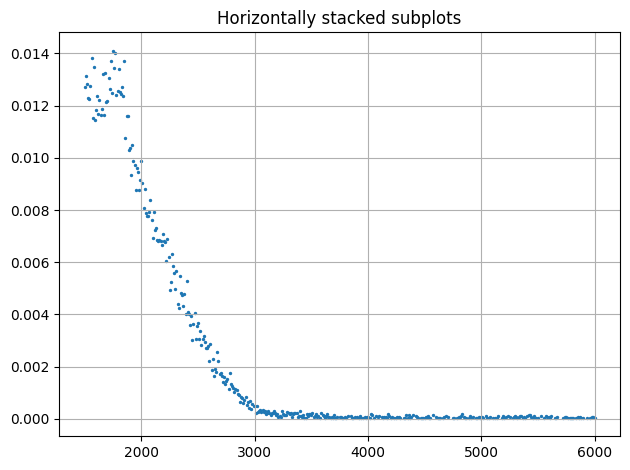

In [230]:
PV_total_weight_and_cumper = pd.DataFrame(PV['Total Weight'].value_counts()).reset_index()
PV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
PV_total_weight_and_cumper['Percentage'] = PV_total_weight_and_cumper['Count'] / total_cars
# Before Sorting
x_data1 = np.log10( PV_total_weight_and_cumper['Total Weight'])
x_data = PV_total_weight_and_cumper['Total Weight']
y_data = PV_total_weight_and_cumper['Percentage']
y_data1 = np.log10(PV_total_weight_and_cumper['Percentage'])


plt.title('Horizontally stacked subplots')
plt.scatter(x_data, y_data , s=2)
plt.tight_layout()
plt.grid()
plt.show()

# ! Sort
PV_total_weight_and_cumper = PV_total_weight_and_cumper.sort_values('Total Weight')
PV_total_weight_and_cumper['Cumulative Probability'] = PV_total_weight_and_cumper['Percentage'].cumsum()


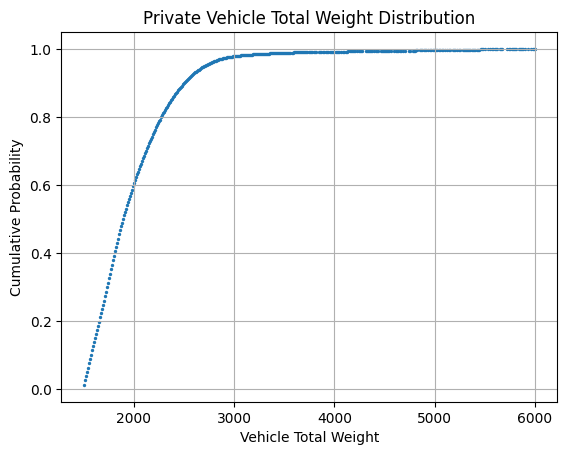

In [231]:
plt.scatter(PV_total_weight_and_cumper['Total Weight'], PV_total_weight_and_cumper['Cumulative Probability'] , s=2)
plt.title('Private Vehicle Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

In [232]:
# from sklearn.model_selection import train_test_split
# X_train,X_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.1, random_state=42)


In [265]:
from keras.models import Sequential
from keras.layers import Dense

# PV_total_weight_and_cumper['Total Weight'] = np.log(PV_total_weight_and_cumper['Total Weight'])
X_train       = PV_total_weight_and_cumper['Total Weight']
y_train       = PV_total_weight_and_cumper['Cumulative Probability']

# essential preprocessing: imputation; substitute any 'NaN' with mean value 
X_train      = X_train.fillna(X_train.mean())


# parameters for keras
input_dim        =  1 # number of neurons in the input layer
n_neurons        =  50       # number of neurons in the first hidden layer
epochs           = 1000       # number of training cycles

# keras model
model = Sequential()        # a model consisting of successive layers
# input layer
model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))
# output layer, with one neuron
model.add(Dense(n_neurons, activation = 'linear'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'tanh'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'tanh'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal'))
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
history = model.fit(y_train,X_train, epochs=epochs, verbose=0,validation_split=0.2)

# use the model to predict the prices for the test data
x_predicted = model.predict(y_train)

12/12 [==============================] - 0s 560us/step


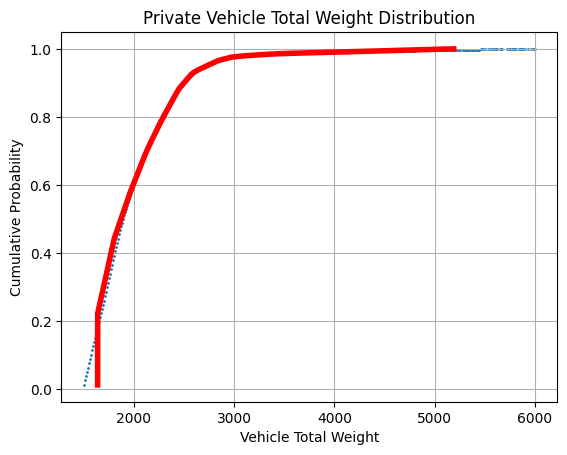

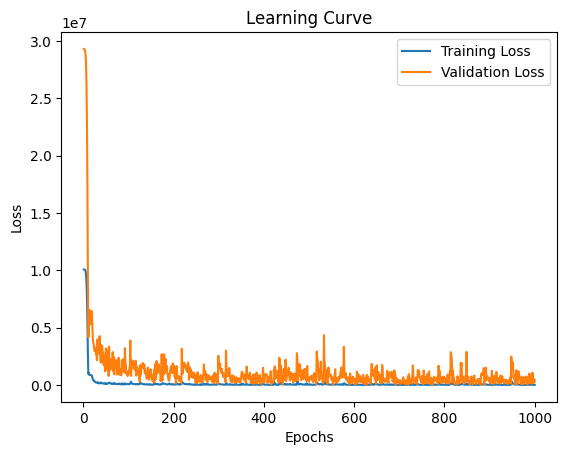

In [266]:
# Display the result
plt.scatter(X_train, y_train, s=1)
plt.plot(x_predicted, y_train, 'r', linewidth=4)
plt.title('Private Vehicle Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

# Extract the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the learning curve
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


In [235]:
# history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=300)

# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.title('Model Mean Squared Error')
# plt.ylabel('Mean Squared Error')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

## HDV Weight Distribution. referenced from [Here](https://colab.research.google.com/drive/11A5Td8nxGSbThzL0NPwwv-E5GpBa0Fv9#scrollTo=sMvpBFj5x1L0)

In [236]:
HDV_total_weight_and_cumper = pd.DataFrame(HDV['Total Weight'].value_counts()).reset_index()
HDV_total_weight_and_cumper.columns = ['Total Weight', 'Count']
HDV_total_weight_and_cumper['Percentage'] = HDV_total_weight_and_cumper['Count'] / total_trucks
# Sort it by Weight First or it messes up the Cumu Prob
HDV_total_weight_and_cumper = HDV_total_weight_and_cumper.sort_values("Total Weight")
HDV_total_weight_and_cumper['Cumulative Probability'] = HDV_total_weight_and_cumper['Percentage'].cumsum()

['Total Weight', 'Count', 'Percentage', 'Cumulative Probability']


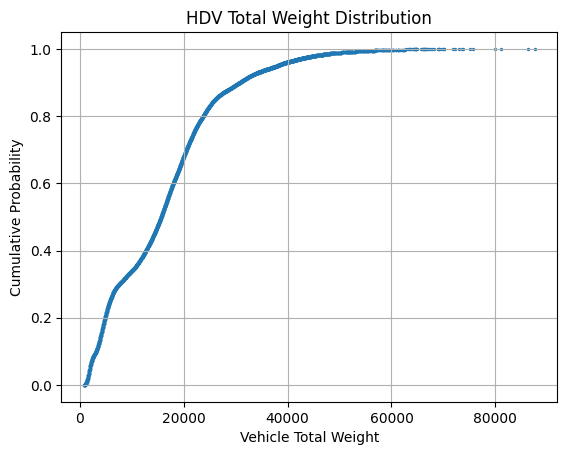

In [237]:
print(list(HDV_total_weight_and_cumper))
truck_x_data = HDV_total_weight_and_cumper['Total Weight']
truck_y_data = HDV_total_weight_and_cumper['Cumulative Probability']
plt.scatter(truck_x_data, truck_y_data , s=2)
plt.title('HDV Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

In [238]:
# # Create the model 
# truck_model = keras.Sequential()
# truck_model.add(keras.layers.Dense(units = 1, activation = 'linear', input_shape=[1]))
# truck_model.add(keras.layers.Dense(units = 64, activation = 'sigmoid'))
# truck_model.add(keras.layers.Dense(units = 64, activation = 'sigmoid'))
# truck_model.add(keras.layers.Dense(units = 64, activation = 'sigmoid'))
# truck_model.add(keras.layers.Dense(units = 64, activation = 'sigmoid'))
# truck_model.add(keras.layers.Dense(units = 64, activation = 'sigmoid'))
# truck_model.add(keras.layers.Dense(units = 1, activation = 'linear'))
# truck_model.compile(loss='mse', optimizer="adam")

# # Display the truck_model
# truck_model.summary()

# Create the model 
# Building NN 
from keras.models import Sequential
from keras.layers import Dense

X_train       = truck_x_data
y_train       = truck_y_data

# essential preprocessing: imputation; substitute any 'NaN' with mean value 
X_train      = X_train.fillna(X_train.mean())


# parameters for keras
input_dim        =  1 # number of neurons in the input layer
n_neurons        =  25       # number of neurons in the first hidden layer
epochs           = 150       # number of training cycles

# keras model
model = Sequential()        # a model consisting of successive layers
# input layer
model.add(Dense(n_neurons, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu'))
# output layer, with one neuron
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(n_neurons, activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal'))
# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
model.fit(y_train,X_train, epochs=epochs, verbose=0)

# use the model to predict the prices for the test data
x_predicted = model.predict(y_train)


147/147 [==============================] - 0s 337us/step


In [239]:
# Training
# model.fit( truck_y_data, truck_x_data, epochs=200, verbose=1)

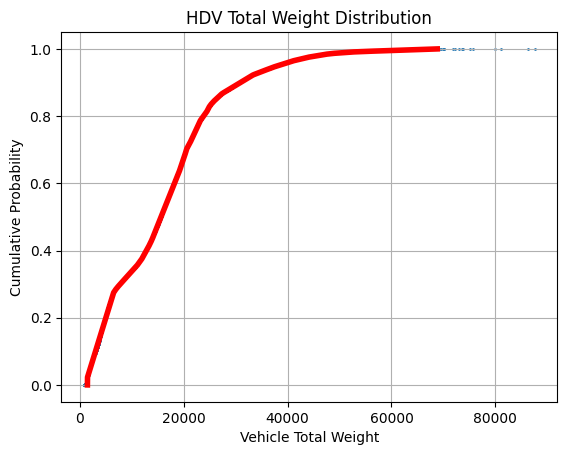

In [240]:
# Compute the output 
# truck_x_predicted = model.predict(truck_y_data)

# Display the result
plt.scatter(truck_x_data[::1], truck_y_data[::1], s=1)
plt.plot(x_predicted, truck_y_data, 'r', linewidth=4)
plt.title('HDV Total Weight Distribution')
plt.xlabel('Vehicle Total Weight')
plt.ylabel('Cumulative Probability')
plt.grid()
plt.show()

In [241]:
truck_x_predicted = model.predict(np.array([1]).reshape(-1,1))
print(truck_x_predicted)

1/1 [==============================] - 0s 38ms/step
[[68816.234]]


## Vehicle Class and Axle Weight and Spacing Distribution